In [ ]:
%load_ext autoreload
%autoreload 2
from ridge_utils.DataSequence import DataSequence
import pandas as pd
import matplotlib.pyplot as plt
from os.path import dirname
import os
from tqdm import tqdm
from neuro.features import qa_questions, feature_spaces
from neuro.data import story_names, response_utils
from neuro.features.stim_utils import load_story_wordseqs, load_story_wordseqs_huge
import neuro.config
import seaborn as sns
import numpy as np
import joblib
from collections import defaultdict
from os.path import join

In [ ]:
def get_fmri_and_labs(story_name='onapproachtopluto', train_or_test='test', subject='uts03'):
    '''
    Returns
    -------
    df : pd.DataFrame
        The fMRI features, with columns corresponding to the principal components
        of the fMRI data.
    labs : pd.DataFrame
        Binary labeled annotations for each of the texts
    texts: 
        The texts corresponding to the rows of df
    '''
    df = joblib.load(f'{subject}/{train_or_test}/{story_name}.pkl')
    dfs = []
    for offset in [1, 2, 3, 4]:
        df_offset = df.shift(-offset)
        df_offset.columns = [col + f'_{offset}' for col in df.columns]
        dfs.append(df_offset)
    df = pd.concat(dfs, axis=1)  # .dropna()  # would want to dropna here

    # load labels
    labs = joblib.load(f'labels/{train_or_test}/{story_name}_labels.pkl')

    # drop rows with nans
    idxs_na = df.isna().sum(axis=1).values > 0
    df = df[~idxs_na]
    labs = labs[~idxs_na]
    texts = pd.Series(df.index)
    return df, labs, texts

In [ ]:
# load a single story
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV
df, labs, texts = get_fmri_and_labs()

# load all the data for a single subject
for subject in ['uts01', 'uts02', 'uts03']:
    data = defaultdict(list)
    for train_or_test in ['test', 'train']:
        story_names_list = os.listdir(f'{subject}/{train_or_test}')
        for story_name in story_names_list:
            df, labs, texts = get_fmri_and_labs(
                story_name.replace('.pkl', ''), train_or_test, subject)
            data['df_' + train_or_test].append(df)
            data['labs_' + train_or_test].append(labs)
            data['texts_' + train_or_test].append(texts)
    for k in data:
        data[k] = pd.concat(data[k], axis=0)

    # example fit linear decoder
    r = defaultdict(list)
    for label_num in tqdm(range(data['labs_train'].shape[1])):
        X_train, y_train = data['df_train'].values, data['labs_train'].values[:, label_num]
        X_test, y_test = data['df_test'].values, data['labs_test'].values[:, label_num]

        # balance the binary class imbalance
        try:
            rus = RandomUnderSampler(random_state=42)
            X_train, y_train = rus.fit_resample(X_train, y_train)
            X_test, y_test = rus.fit_resample(X_test, y_test)

            if len(y_test) < 30:
                print('too few positive labels', label_num)
                continue

            print('label', label_num,
                  data['labs_train'].columns[label_num], X_train.shape, X_test.shape)
            m = LogisticRegressionCV(random_state=42)
            m.fit(X_train, y_train)
            print(
                f"""\ttest acc {m.score(X_test, y_test):.3f}\n\tnaive acc {1 -y_test.mean():.3f}""")
            r['label'].append(data['labs_train'].columns[label_num])
            r['test_acc'].append(m.score(X_test, y_test))
            r['num_test'].append(len(y_test))
            r['coef'].append(m.coef_.copy())
        except:
            print('error for', label_num)
            continue
    r_df = pd.DataFrame(r)
    # .sort_values(
    # 'test_acc', ascending=False).reset_index()
    r_df.to_pickle(f'r_df_{subject}.pkl')

mean acc 0.6578285878997154
mean acc 0.6298550422379504
mean acc 0.6674364172732555
mean acc 0.67619430418794


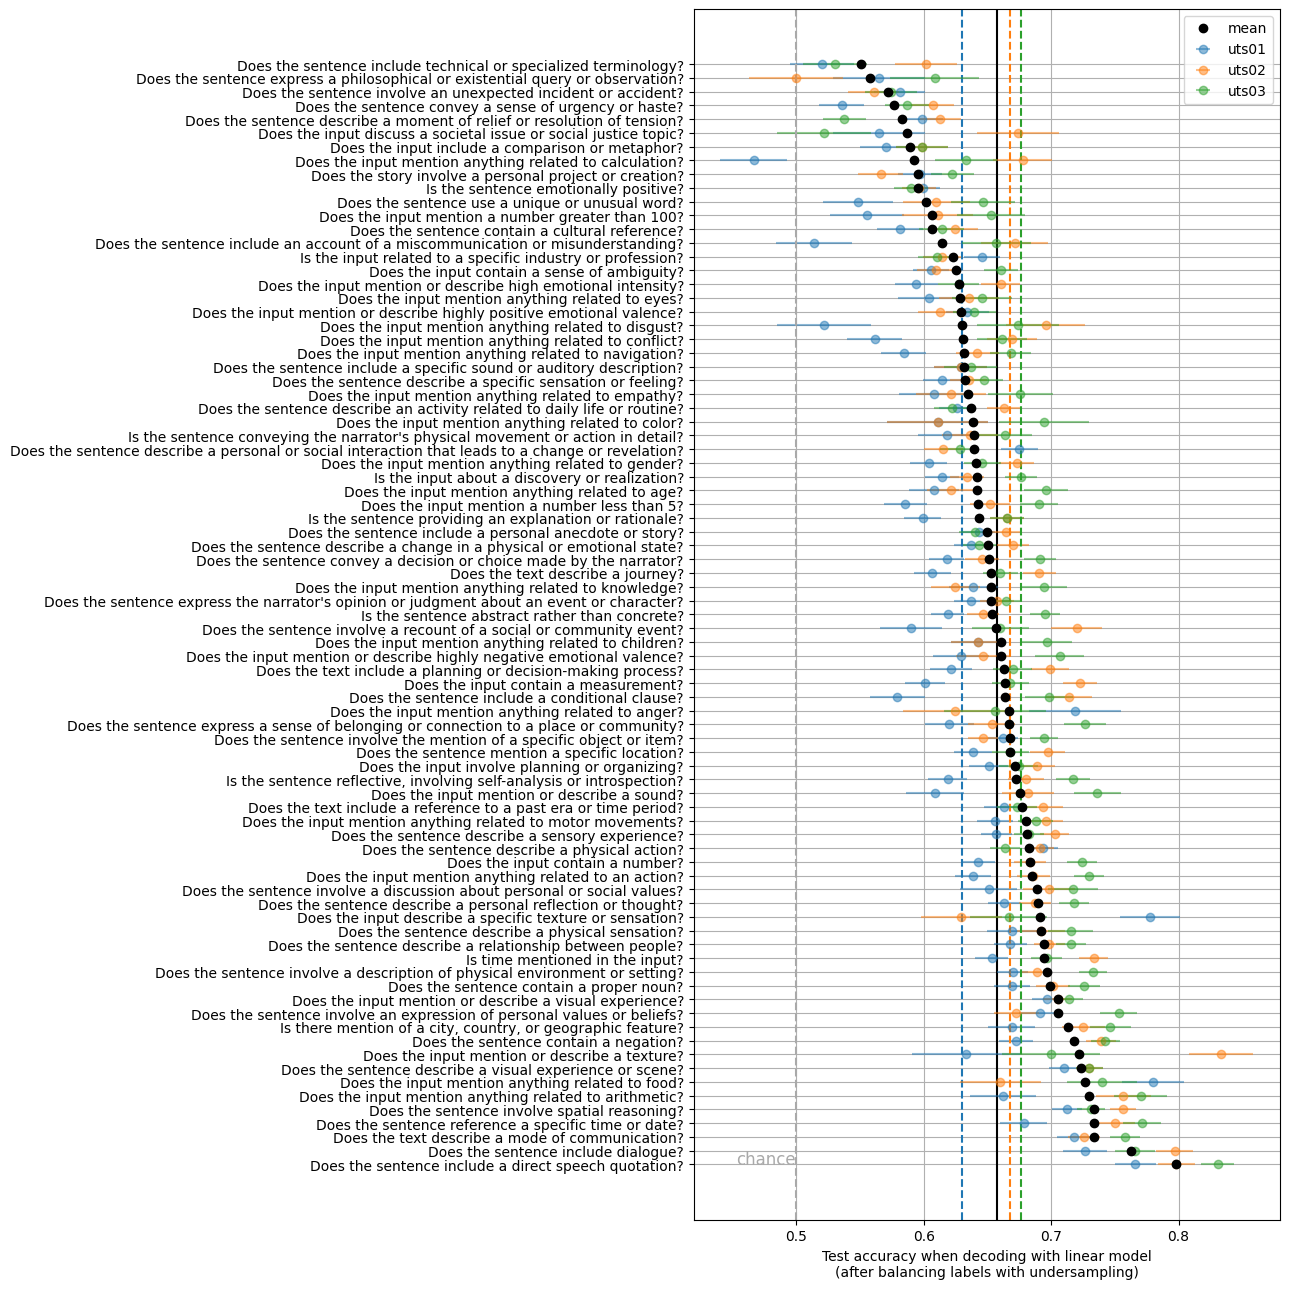

In [31]:
plt.figure(figsize=(13, 13))
colors = {
    'uts01': 'C0',
    'uts02': 'C1',
    'uts03': 'C2',
    'mean': 'black'
}
for subject in ['mean', 'uts01', 'uts02', 'uts03']:
    if subject == 'mean':
        dfs = [pd.read_pickle(f'r_df_{subject}.pkl')
               for subject in ['uts01', 'uts02', 'uts03']]
        r_df = pd.concat(dfs, axis=0).groupby('label').mean().reset_index()
        idx_sort = r_df['test_acc'].sort_values(ascending=False).index
    else:
        r_df = pd.read_pickle(f'r_df_{subject}.pkl')

    r_df = r_df.loc[idx_sort]

    # plot accuracy with binomial error bars
    if subject == 'mean':
        plt.errorbar(
            r_df['test_acc'],
            range(len(r_df)),
            color='black',
            fmt='o',
            zorder=1000,
            label=subject,
        )
        plt.axvline(r_df['test_acc'].mean(), color=colors[subject])
    else:
        plt.errorbar(
            r_df['test_acc'],
            range(len(r_df)),
            xerr=(r_df['test_acc']*(1-r_df['test_acc']) /
                  np.sqrt(r_df['num_test'])),
            alpha=0.5,
            label=subject,
            fmt='o')
        plt.axvline(r_df['test_acc'].mean(),
                    linestyle='--', color=colors[subject])

    print('mean acc', r_df['test_acc'].mean())

# add horizontal bars
plt.yticks(range(len(r_df)), r_df['label'])
plt.xlabel(
    'Test accuracy when decoding with linear model\n(after balancing labels with undersampling)')
plt.grid()

# annotate with baseline and text label
plt.axvline(0.5, color='darkgray', linestyle='--')
plt.text(0.5, 0, 'chance', color='darkgray', fontsize=12, ha='right')
plt.tight_layout()
plt.savefig('linear_decoding.png', dpi=300)
plt.legend()
plt.show()

# Visualize learned coefs on cortex map

In [ ]:
subject = 'uts03'

In [ ]:
pca_comps = joblib.load(f'{subject}/pca_components.pkl')
# vertically stack pca_comps 4 times
pca_comps = np.vstack([pca_comps]*4)

In [ ]:
def quickshow(X: np.ndarray, subject="UTS03", fname_save=None, title=None):
    import cortex

    """
    Actual visualizations
    Note: for this to work, need to point the cortex config filestore to the `ds003020/derivative/pycortex-db` directory.
    This might look something like `/home/chansingh/mntv1/deep-fMRI/data/ds003020/derivative/pycortex-db/UTS03/anatomicals/`
    """
    vol = cortex.Volume(X, subject, xfmname=f"{subject}_auto")
    # , with_curvature=True, with_sulci=True)
    vabs = max(abs(vol.data.min()), abs(vol.data.max()))
    vol.vmin = -vabs
    vol.vmax = vabs
    # fig = plt.figure()
    # , vmin=-vabs, vmax=vabs)
    cortex.quickshow(vol, with_rois=True, cmap="PuBu")
    # fig = plt.gcf()
    # add title
    # fig.axes[0].set_title(title, fontsize='xx-small')
    if fname_save is not None:
        plt.savefig(fname_save)
        # plt.savefig(fname_save.replace(".pdf", ".png"))
        plt.close()

In [ ]:
for i in range(len(r_df)):
    pc_coef = r_df.iloc[i]['coef']
    voxel_coefs = (pc_coef @ pca_comps).squeeze()
    quickshow(voxel_coefs, fname_save=join(
        'flatmaps_decoding', f'{r_df.iloc[i]["label"]}.pdf'))